In [1]:
import numpy as np
import pandas as pd

from coactivation.process import *
from coactivation.visualize import *

# MyHand Coactivation Demo

**coactivation map:** a profile of the strength of each EMG channel activation per class (open, close, relax), created from the median amplitudes of EMG grouped by class and EMG channel (0-7).

The functions used in this demo are either from `coactivation/process.py` or `coactivation/visualize.py`. Anything that outputs a plot is from `visualize`, and everything else is from `process`.

## Creating dataset of coactivation maps from all collected data
Each datapoint is defined by one subject session:
* coactivation map (24 dimensions)
* folder (date)
* subject_id
* hand (right or left)
* set (static, dynamic, etc.)
* subset (resting, reaching, etc.), and
* is_patient (True or False)

In [2]:
df = generate_coactivation_dataset()
df

,gt0emg0,gt0emg1,gt0emg2,gt0emg3,gt0emg4,gt0emg5,gt0emg6,gt0emg7,gt1emg0,gt1emg1,...,gt2emg4,gt2emg5,gt2emg6,gt2emg7,folder,subject_id,hand,set_num,subset,is_patient
0,0.015625,0.023438,0.015625,0.015625,0.007812,0.007812,0.007812,0.007812,0.023438,0.054688,...,0.015625,0.015625,0.023438,0.046875,2025_02_21,yz,nan,static,resting,False
0,0.015625,0.039062,0.062500,0.117188,0.023438,0.015625,0.023438,0.015625,0.085938,0.054688,...,0.085938,0.031250,0.054688,0.101562,2025_02_21,om,nan,static,reaching,False
0,0.015625,0.031250,0.054688,0.117188,0.031250,0.015625,0.015625,0.007812,0.062500,0.054688,...,0.117188,0.046875,0.070312,0.117188,2025_02_21,om,nan,static,unsupported,False
0,0.015625,0.101562,0.140625,0.054688,0.015625,0.023438,0.078125,0.046875,0.085938,0.156250,...,0.078125,0.039062,0.101562,0.117188,2025_02_21,om,nan,static,resting,False
0,0.007812,0.007812,0.015625,0.007812,0.007812,0.007812,0.007812,0.007812,0.046875,0.046875,...,0.062500,0.023438,0.023438,0.031250,2025_02_21,mk,nan,static,resting,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.007812,0.007812,0.007812,0.015625,0.023438,0.015625,0.007812,0.007812,0.007812,0.023438,...,0.062500,0.031250,0.031250,0.039062,2025_02_07,si,left,static,unsupported,False
0,0.007812,0.007812,0.015625,0.015625,0.007812,0.007812,0.007812,0.007812,0.015625,0.023438,...,0.023438,0.015625,0.015625,0.015625,2025_02_07,si,left,static,resting,False
0,0.007812,0.007812,0.015625,0.023438,0.023438,0.015625,0.007812,0.007812,0.007812,0.031250,...,0.031250,0.015625,0.023438,0.031250,2025_02_07,ls,nan,static,unsupported,False
0,0.023438,0.031250,0.031250,0.023438,0.023438,0.007812,0.015625,0.015625,0.054688,0.070312,...,0.031250,0.023438,0.031250,0.062500,2025_02_07,bw,nan,static,hanging,False


### Visualizing one subject's coactivation map 

#### From the dataset created above

In [3]:
# picking a random index from the dataset and extracting the coactivation map
cm_array = df.iloc[100].values[:24] # first 24 values
# convert extracted array to coactivation map 3x8 dataframe
cm = array_to_cm(cm_array) 
cm

,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7
gt,,,,,,,,
0,0.007812,0.015625,0.054688,0.03125,0.015625,0.007812,0.007812,0.007812
1,0.09375,0.039062,0.203125,0.25,0.023438,0.015625,0.023438,0.0625
2,0.109375,0.148438,0.148438,0.09375,0.023438,0.023438,0.03125,0.054688


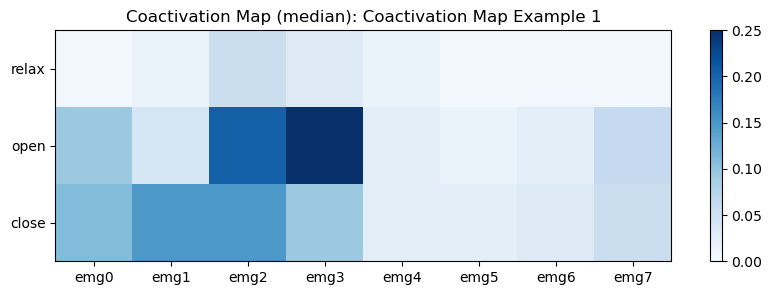

In [4]:
plot_coactivation_map(cm, title='Coactivation Map Example 1')

#### From a raw file

1. preprocess
2. preprocessed --> coactivation map
3. coactivation map --> plot

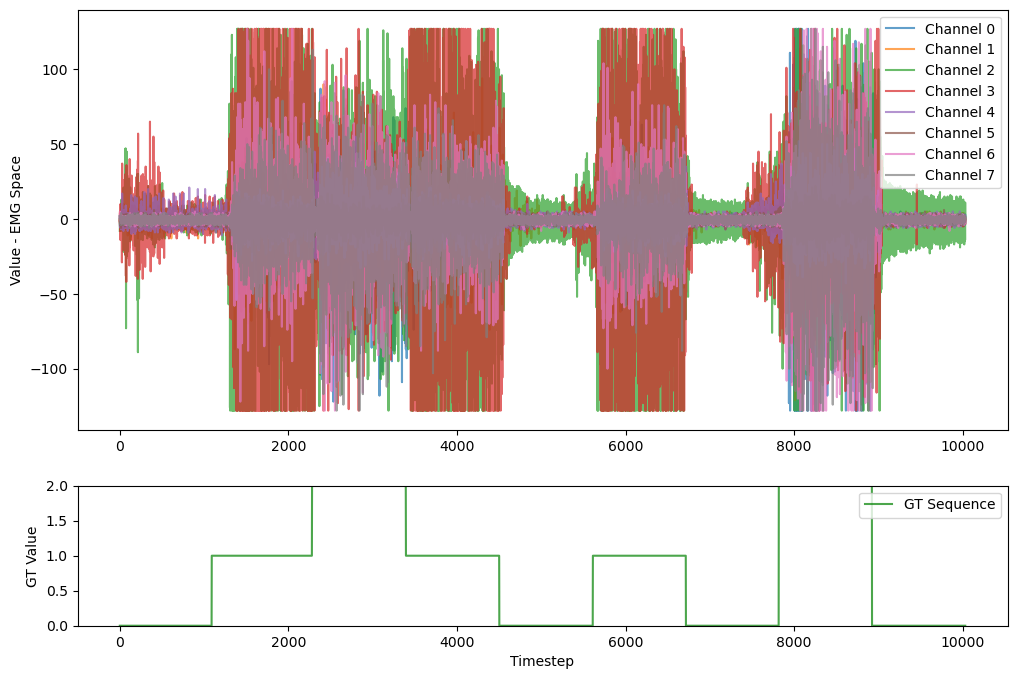

In [5]:
# visualize raw data
visualize_emgs('collected_data/2025_02_07/ec_static_resting.csv')

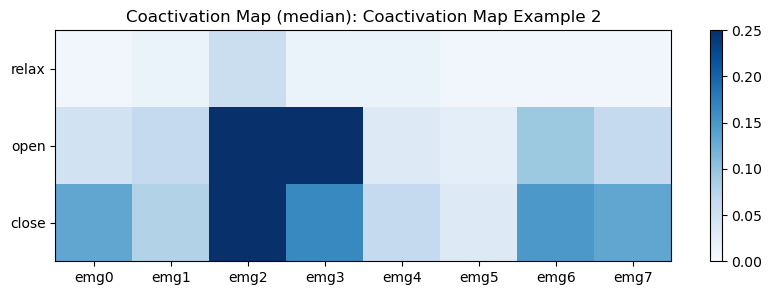

In [6]:
# 1. preprocess
df_preprocessed = preprocess_emgs('collected_data/2025_02_07/ec_static_resting.csv')
# 2. generate coactivation map
cm = get_coactivation_map(df_preprocessed)
# 3. plot
plot_coactivation_map(cm, title='Coactivation Map Example 2')

### K-means analysis example

Stratified by class, by person (average of their coactivations) -- Relax example

In [7]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap

In [8]:
df_avgs = df.iloc[:,np.r_[0:24, 25]].groupby('subject_id').apply('mean') # take average cm of each person
df_relax = df_avgs.iloc[:,:8]
df_open = df_avgs.iloc[:,8:16]
df_close = df_avgs.iloc[:,16:24]

Cluster Centers:
 [[0.01078869 0.01329985 0.01641555 0.01348586 0.01320685 0.0108817
  0.0093936  0.00976562]
 [0.015625   0.04882812 0.07421875 0.078125   0.01953125 0.015625
  0.03320312 0.01953125]
 [0.01422991 0.0234375  0.0359933  0.02762277 0.0186942  0.01199777
  0.01032366 0.0108817 ]]


/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_35050/2527838429.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(pd.DataFrame(df_relax.groupby('cluster').apply(lambda x: np.unique(x.index))))


,0
cluster,
0,"[bg, cc, co, dk, es, hh, hl, jh, jl, ls, mk, m..."
1,[om]
2,"[bw, ec, hz, jp, kj, st, zc]"


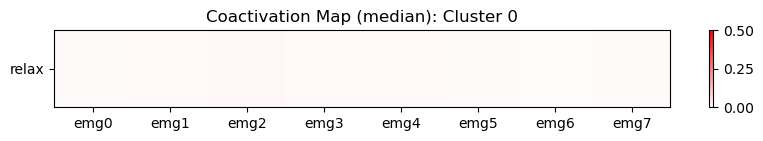

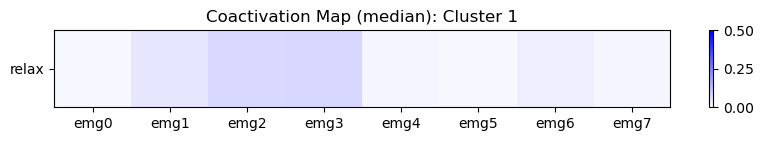

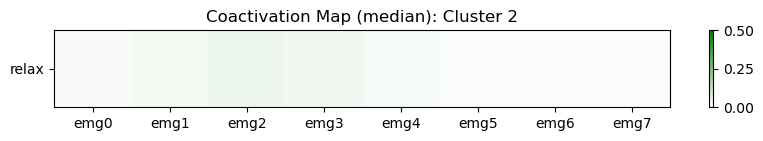

In [9]:
# kmeans example for relax

n_clusters = 3
X = df_relax.values # change df_relax to df_open or df_close for other clustering analysis

kmeans = KMeans(n_clusters=n_clusters,   
                 init='k-means++', 
                 max_iter=300,
                 n_init=10, 
                 tol=1e-4,    
                 random_state=42,    
                 algorithm='lloyd')
df_relax['cluster'] = kmeans.fit_predict(X)
kmeans.fit(X)

labels = kmeans.predict(X)

print("Cluster Centers:\n", kmeans.cluster_centers_)
display(pd.DataFrame(df_relax.groupby('cluster').apply(lambda x: np.unique(x.index))))

tsne_input = df_relax.iloc[:,:24].to_numpy()
data_tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(tsne_input)
data_tsne = pd.DataFrame(data_tsne, columns=['myx', 'myy', 'myz'])
data_tsne['cluster_ids'] = df_relax['cluster'].to_numpy().astype(str)
data_tsne['subject_ids'] = df_relax.index.to_numpy()

unique_clusters = sorted(data_tsne['cluster_ids'].unique())
# palette = px.colors.qualitative.Plotly 
color_map = {
    "0": "red",   
    "1": "blue",   
    "2": "green",  
    "3": "purple" 
}

fig = px.scatter_3d(data_tsne,
                    x='myx', y='myy', z='myz',
                    color='cluster_ids',
                    text='subject_ids',
                    title='Relax: 3D t-SNE for K-means', 
                    color_discrete_map=color_map,
                    category_orders={'cluster_ids': unique_clusters},
)
fig.update_layout(
    legend=dict(
        x=1.15,
        y=0.5, 
        xanchor='left',
        yanchor='middle' 
    )
)

fig.show()
# fig.write_html('relax.html')

for i in range(len(kmeans.cluster_centers_)):
    cmap = LinearSegmentedColormap.from_list("white_to_color", ["white", color_map[str(i)]])
    cluster_center = kmeans.cluster_centers_[i]
    plot_one_class_coactivation_map(cluster_center, title='Cluster ' + str(i), label='relax', cmap=cmap)

### Getting the median healthy coactivation map

In [10]:
# Creating dataset of coactivation maps grouped by ground truth (rest, relax, close) from all collected data
dfgt = generate_coactivation_by_gt()
display(dfgt)

collected_data/2025_02_21
yz_static_resting.csv
om_wrist_movement_open.csv
yz_wrist_movement_relax.csv
mk_grasp_ball.csv
yz_wrist_movement_open.csv
om_arm_movement_relax.csv
yz_arm_movement_close.csv
om_static_reaching.csv
om_static_unsupported.csv
om_wrist_movement_close.csv
mk_wrist_movement_open.csv
om_grasp_soup.csv
yz_grasp_soup.csv
om_static_resting.csv
mk_arm_movement_close.csv
mk_static_resting.csv
yz_arm_movement_open.csv
mk_wrist_movement_relax.csv
mk_arm_movement_relax.csv
mk_static_unsupported.csv
yz_static_reaching.csv
om_static_hanging.csv
yz_static_hanging.csv
mk_wrist_movement_close.csv
mk_static_reaching.csv
mk_grasp_soup.csv
mk_arm_movement_open.csv
yz_wrist_movement_close.csv
yz_arm_movement_relax.csv
om_arm_movement_close.csv
om_arm_movement_open.csv
yz_static_unsupported.csv
yz_grasp_ball.csv
om_wrist_movement_relax.csv
om_grasp_ball.csv
mk_static_hanging.csv
collected_data/2025_02_07_hand_labeled
collected_data/2025_05_06
Spring1_Manual_Calibration.csv
Spring1_Man

,folder,subject_id,hand,set_num,subset,is_patient,gt,window,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7
0,2025_02_21,yz,nan,static,static,False,0,0,0.007812,0.015625,0.015625,0.015625,0.007812,0.007812,0.007812,0.007812
1,2025_02_21,yz,nan,static,static,False,1,1,0.023438,0.062500,0.109375,0.031250,0.015625,0.023438,0.015625,0.015625
2,2025_02_21,yz,nan,static,static,False,2,2,0.093750,0.078125,0.070312,0.062500,0.015625,0.015625,0.023438,0.039062
3,2025_02_21,yz,nan,static,static,False,1,3,0.031250,0.062500,0.113281,0.039062,0.015625,0.023438,0.023438,0.023438
4,2025_02_21,yz,nan,static,static,False,0,4,0.015625,0.023438,0.023438,0.015625,0.007812,0.007812,0.007812,0.007812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2025_02_07,bw,nan,grasp,grasp,False,0,4,0.031250,0.015625,0.023438,0.023438,0.015625,0.015625,0.015625,0.015625
1495,2025_02_07,bw,nan,grasp,grasp,False,2,5,0.218750,0.132812,0.164062,0.132812,0.046875,0.031250,0.039062,0.085938
1496,2025_02_07,bw,nan,grasp,grasp,False,0,6,0.039062,0.023438,0.046875,0.039062,0.015625,0.015625,0.015625,0.015625
1497,2025_02_07,jp,right,arm_movement,arm_movement,False,0,0,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625


In [11]:
cm_healthy = get_all_healthy_map(dfgt)
cm_healthy

,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7
gt,,,,,,,,
0,0.015625,0.015625,0.023438,0.015625,0.015625,0.007812,0.007812,0.007812
1,0.039062,0.046875,0.132812,0.093750,0.031250,0.023438,0.023438,0.031250
2,0.085938,0.085938,0.072266,0.085938,0.046875,0.023438,0.039062,0.046875


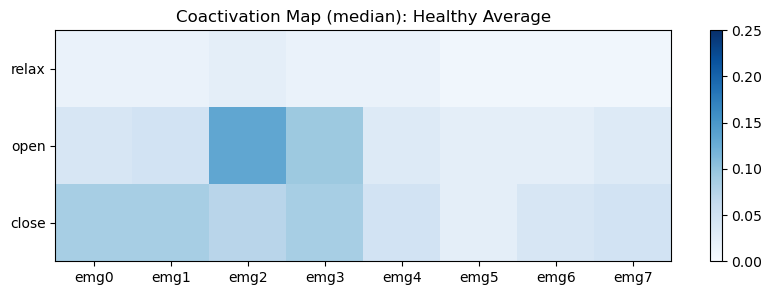

In [12]:
plot_coactivation_map(cm_healthy, title='Healthy Average')

### Similarity metric exploration: Comparing healthy average coactivation maps to each coactiavtion map in dataset

In [13]:
for metric in ['ruzicka', 'g', 'mi', 'gmi']:
    df[metric] = df.iloc[:, :24].apply(lambda x: apply_similarity_metric(x, cm_healthy, metric), axis=1) 
df

/Users/elise/Desktop/myhand-coactivation/myhand-coactivation/coactivation/similarity.py:26: RuntimeWarning:

invalid value encountered in scalar divide

/Users/elise/Desktop/myhand-coactivation/myhand-coactivation/coactivation/similarity.py:26: RuntimeWarning:

invalid value encountered in scalar divide



,gt0emg0,gt0emg1,gt0emg2,gt0emg3,gt0emg4,gt0emg5,gt0emg6,gt0emg7,gt1emg0,gt1emg1,...,folder,subject_id,hand,set_num,subset,is_patient,ruzicka,g,mi,gmi
0,0.015625,0.023438,0.015625,0.015625,0.007812,0.007812,0.007812,0.007812,0.023438,0.054688,...,2025_02_21,yz,nan,static,resting,False,2.170629,0.090495,1.572306,0.177659
0,0.015625,0.039062,0.062500,0.117188,0.023438,0.015625,0.023438,0.015625,0.085938,0.054688,...,2025_02_21,om,nan,static,reaching,False,1.927449,0.131510,1.738972,0.279867
0,0.015625,0.031250,0.054688,0.117188,0.031250,0.015625,0.015625,0.007812,0.062500,0.054688,...,2025_02_21,om,nan,static,unsupported,False,1.823240,0.134115,1.822306,0.284584
0,0.015625,0.101562,0.140625,0.054688,0.015625,0.023438,0.078125,0.046875,0.085938,0.156250,...,2025_02_21,om,nan,static,resting,False,2.095759,0.128906,1.937093,0.276452
0,0.007812,0.007812,0.015625,0.007812,0.007812,0.007812,0.007812,0.007812,0.046875,0.046875,...,2025_02_21,mk,nan,static,resting,False,2.171888,0.106120,1.284948,0.169904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.007812,0.007812,0.007812,0.015625,0.023438,0.015625,0.007812,0.007812,0.007812,0.023438,...,2025_02_07,si,left,static,unsupported,False,2.008678,0.061849,0.870024,0.083799
0,0.007812,0.007812,0.015625,0.015625,0.007812,0.007812,0.007812,0.007812,0.015625,0.023438,...,2025_02_07,si,left,static,resting,False,2.242717,0.062500,0.957519,0.097691
0,0.007812,0.007812,0.015625,0.023438,0.023438,0.015625,0.007812,0.007812,0.007812,0.031250,...,2025_02_07,ls,nan,static,unsupported,False,2.036772,0.074870,1.155639,0.103450
0,0.023438,0.031250,0.031250,0.023438,0.023438,0.007812,0.015625,0.015625,0.054688,0.070312,...,2025_02_07,bw,nan,static,hanging,False,2.317628,0.121745,1.770426,0.251252


### Other visualizing functions that were not used in demo

#### `plot_coactivation_map_with_histograms`

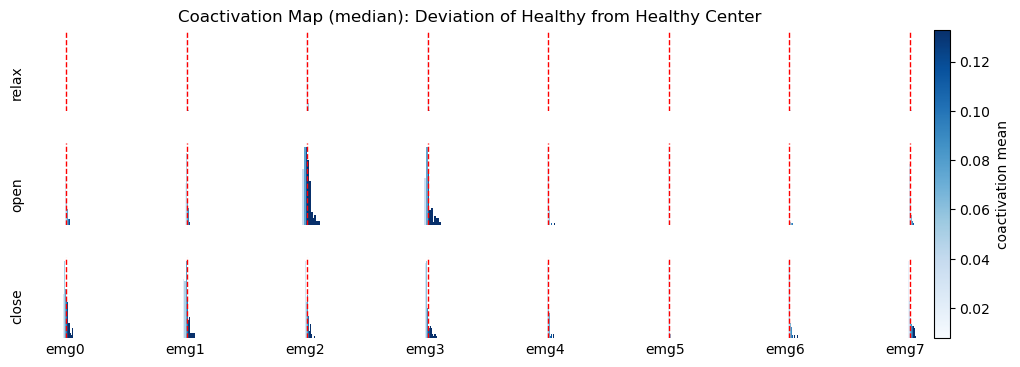

In [14]:
df_left_mirrored = mirror_emg(df)

plot_coactivation_map_with_histograms(df_left_mirrored.iloc[:,:24].values.reshape(len(df_left_mirrored),3,8), cm_healthy.values.reshape(3,8), title='Deviation of Healthy from Healthy Center')

#### `visualize_stratified_median_emgs`

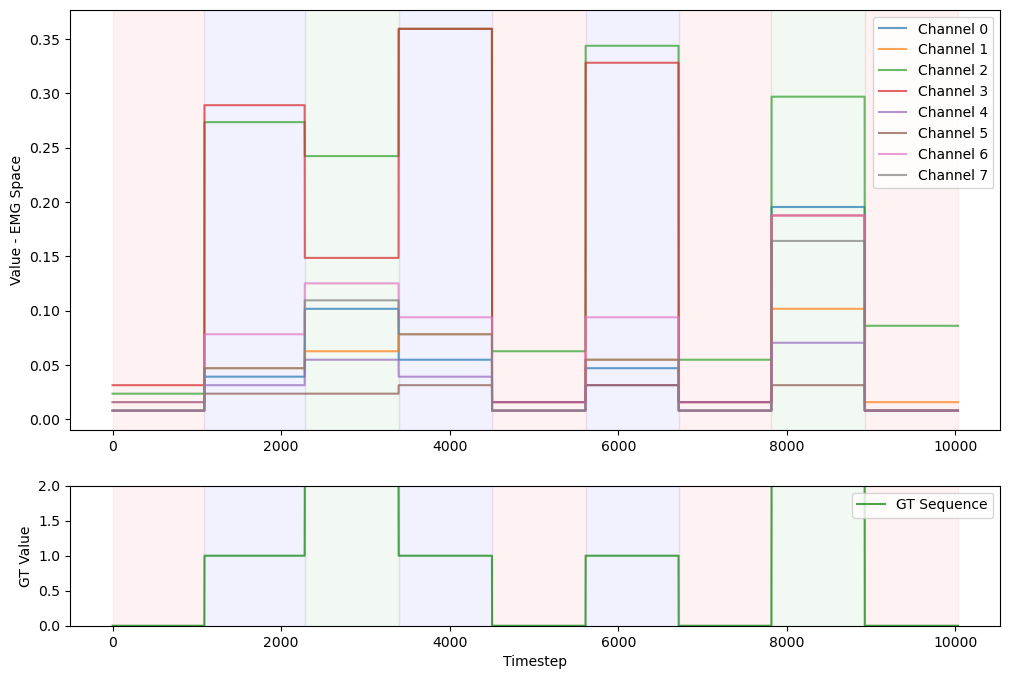

In [15]:
visualize_stratified_median_emgs('collected_data/2025_02_07/ec_static_resting.csv')